In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from sklearn.cluster import DBSCAN

In [2]:
def edit_df(df, i, j):
    """
    function to drop empty cells and separate the type of additive compound and its volume.
    df: pd.DataFrame
        headers include information about the amount of HCl,
        the first row has wavelength and absorbance like header row,
        other cells have numerical values,
        there are some unnecessary & missing values as well.
    i: int, start column
    j: int, end column
    """
    # Remove null values of each HCl column.
    temp = df.iloc[1:, i:j].dropna()
    
    # Take the information about the additive & the amount of it from the header.
    cols = temp.columns
    add = (cols[0]).split(' ')
    if add[-1] != "hcl":
        additive = 'hcl'
        vol = 0
    else:
        additive = add[-1]
        vol = eval(add[0])
    temp = temp.rename(columns = {cols[0] : "wavelength",
                                 cols[1] : "absorbance"})
    temp['additive'] = additive
    temp['volume(mm)'] = vol
    return temp


def data_transformer(df):
    """
    function to transform the shape of dataframe.
    df: pd.DataFrame
    """
    # Remove unnecessary cells by detercting an empty row.
    df = df.dropna(axis = 1,
                  how = "all")
    idx = df.index[data.isnull().all(axis=1)].tolist()
    if len(idx) > 0:
        df = df.iloc[:idx[0], :]
    
    # Create the transformed data frame.
    transformed_df = pd.DataFrame()
    iter = int(len(df.columns) // 2)
    for i in range(iter):
        temp = edit_df(df, (2 * i), (2 * i + 2))
        transformed_df = pd.concat([transformed_df, temp])

    return transformed_df.reset_index(drop = True)


def check_the_plot(df, title):
    """
    A function to plot a pivoted table in a scattered plot format.
    df: pd.Dataframe, 
        table with indices as a group, columns as x-axis values. The values will be plotted on y-axis.
    title: str, 
           title of the plot.
    """
    plt.figure(figsize = (10, 6))
    x_data = df.columns

    for i in df.index:
        y_data = df.loc[i]
        plt.plot(x_data, y_data, label = f"{i} mm")

    plt.xlabel("Wavelength (nm)", fontsize = 14)
    plt.ylabel("Absorbance", fontsize = 14)
    plt.title(title,
             fontsize = 18,
             weight = "bold")
    plt.legend(loc = "upper right",
              title = "HCl")
    plt.show()
    
    
def getting_peaks(array:pd.Series,
                  height = 0.1, 
                  distance = 10, 
                  width = 1, 
                  negative = False):
    """
    A function to find peaks and return the pd.Series shaped data points of the peaks.
    array: pd.Series,
           array of x-axis & y-axis data points.
    height: float,
            required hight of peaks. 
    distance: int,
              required minimal horizontal distance (>= 1) in samples between neighbouring peaks.
    width: int,
           required width of peaks in samples.
    negative: boolean,
              find negative side peaks if True, find positive peaks if False.
    """
    if negative:
        array = - array
        
    peaks, _ = find_peaks(array, 
                          height = height,
                          distance = distance,
                          width = width)
    if negative:
        return -array.iloc[peaks]
    else:
        return array.iloc[peaks]
     
     
# Hyperparameter
MAX_SIGMOID = 1.5

def reverse_sigmoid(x, x0, k):
    """
    A function to return the value fitted the reversed sigmoid graph. 
    x0: the centre of the sigmoid graph.
    k: parameter to control how steep is the graph.
    """
    return MAX_SIGMOID / (1 + np.exp(k * (x - x0)))

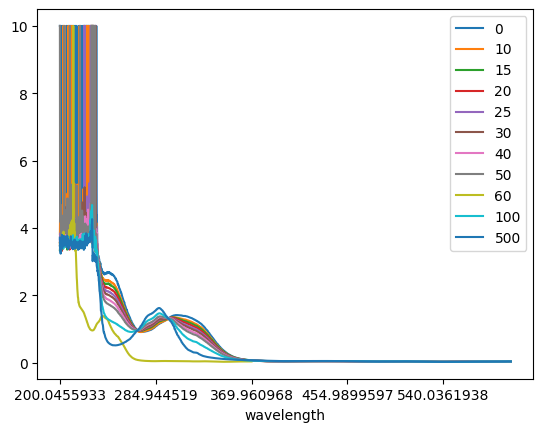

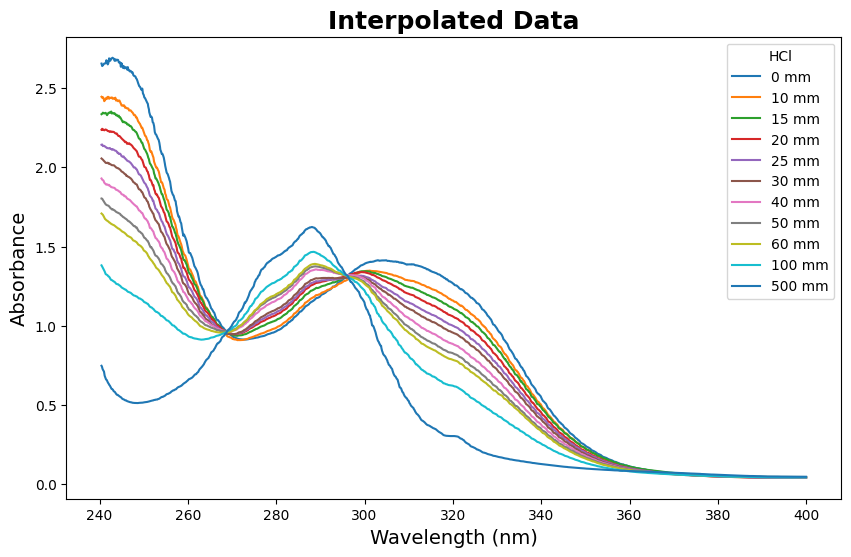

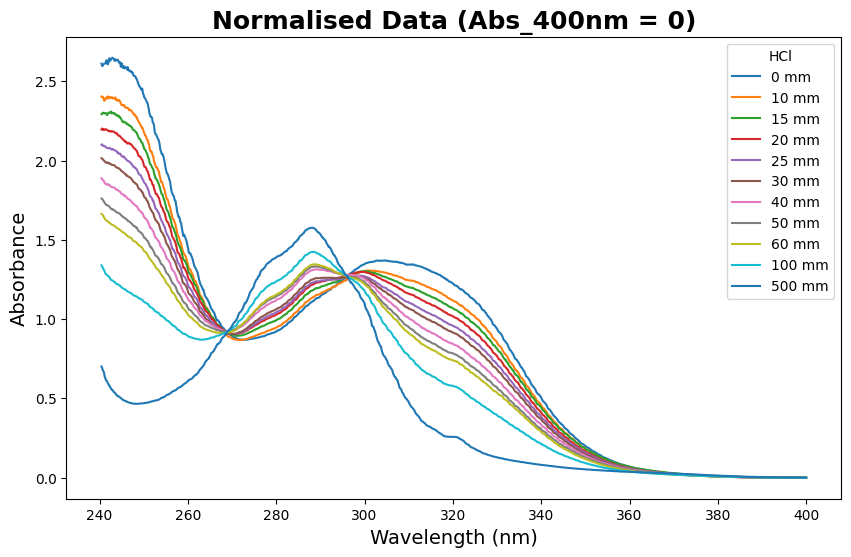

In [4]:
# Import the dataset & Transform it.
data = pd.read_excel('../data/PDNTBA pKa scans.xls',
                    sheet_name="pdntba20mmscan2")
df = data_transformer(data)


# Check the plot of the original raw data.
temp = (df.sort_values(['wavelength'])).copy()
temp.set_index('wavelength', inplace = True)
temp.groupby('volume(mm)')['absorbance'].plot(legend = True);


# It seems like the ranges of wavelength lower than 240 and bigger than 400 are not very necessary.
# In this case, we can cut them off from the dataset.
df = df[(df.wavelength > 240) & (df.wavelength < 400)]


# Pivot the table with HCl volume as index and wavelength as column
pivot_df = pd.pivot_table(df,
                           columns="wavelength",
                           index="volume(mm)",
                           values="absorbance")

# Mismatched wavelength between HCl 500mm and others. >> Many missing values!
pivot_df.isna().sum().sum()  # 11256


# Fill the missing values with interpolation method.
intpl_df = pivot_df.apply(pd.to_numeric, errors = "coerce").interpolate(method = "linear",
                                  axis = 1)
intpl_df.isna().sum().sum()  # 13

# We can drop missing values as they are not many.
intpl_df = intpl_df.dropna(axis = 1)

# Check the plot.
check_the_plot(intpl_df, "Interpolated Data")


# Normalise the dataset as the absorbance at wavelength = 400nm equals to 0.
norm_df = intpl_df.copy()

for hcl in norm_df.index:
    abs_400 = (norm_df.loc[hcl]).values[-1]  # the absorbance value at the biggiest wavelength.
    norm_df.loc[hcl] = (norm_df.loc[hcl]).sub(abs_400)

check_the_plot(norm_df, "Normalised Data (Abs_400nm = 0)")

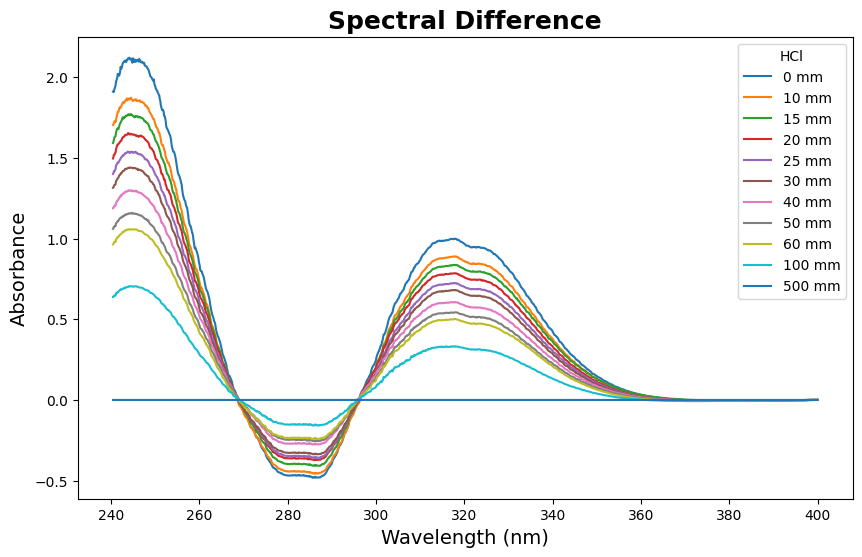

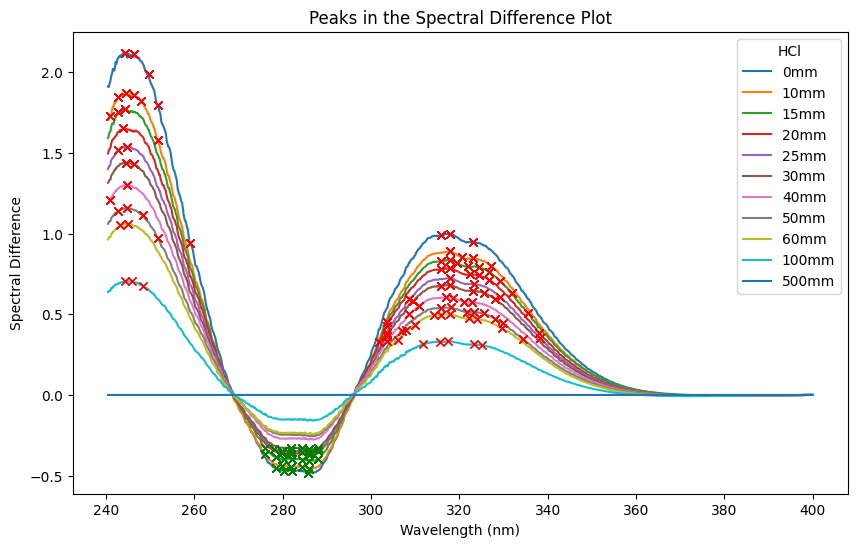

In [5]:
# Get the spectral differences based on the acid(HCl = 500 mm).
spec_diff = norm_df.subtract(norm_df.loc[500], axis = 1)
check_the_plot(spec_diff, "Spectral Difference")


# Find positive/negative peaks separately and check the plot.
# Hyperparameters
HEIGHT = 0.3
DISTANCE = 20
WIDTH = 1

pos_peaks = pd.Series()
neg_peaks = pd.Series()

plt.figure(figsize = (10, 6))

for idx in spec_diff.index:
    series = spec_diff.loc[idx]
    plt.plot(series, label = f"{idx}mm")
    
    pos_peak = getting_peaks(series,
                             height=HEIGHT,
                             distance=DISTANCE,
                             width=WIDTH)
    pos_peaks = pd.concat([pos_peaks, pos_peak])
    
    neg_peak = getting_peaks(series,
                             height=HEIGHT,
                             distance=DISTANCE,
                             width=WIDTH,
                             negative=True)
    neg_peaks = pd.concat([neg_peaks, neg_peak])
    
    plt.plot(pos_peaks, "x", color = "red")
    plt.plot(neg_peaks, "x", color = "green")

plt.title("Peaks in the Spectral Difference Plot")
plt.legend(loc="upper right",
              title = "HCl")
plt.xlabel('Wavelength (nm)')
plt.ylabel("Spectral Difference")
plt.show()

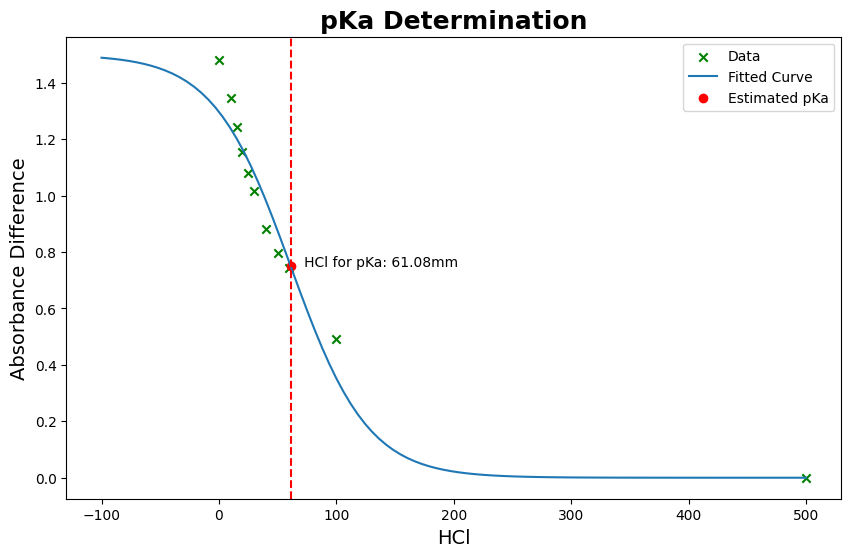

In [6]:
# Find clusters of each peak group with DBScan method.
pos = np.array(list(zip(pos_peaks.index, pos_peaks)))
neg = np.array(list(zip(neg_peaks.index, neg_peaks)))

# Hyperparameters
EPS = 10
MIN_SAMPLES = 10

# Positive peaks
pos_db = DBSCAN(eps = EPS, min_samples = MIN_SAMPLES)
pos_db.fit(pos)

# Negative peaks
neg_db = DBSCAN(eps = EPS, min_samples = MIN_SAMPLES)
neg_db.fit(neg)


# Find the cluster with better consistency - smaller variance inbetween each absorbance value.
labels = np.unique(pos_db.labels_)
pos_group = 0
min_var = 10


if len(labels) > 1: # Compare the variances of each cluster.
    for label in labels:
        var_cluster = (pos[pos_db.labels_ == label][:, 1]).var()
        if min_var > var_cluster:
            min_var = var_cluster
            pos_group = label
        else:
            continue
else: # There is no choice if there is only one cluster.
    pos_group = labels[0]

# Get the wavelength with the maximum absorbance from positive peaks.
t = pd.DataFrame(pos[pos_db.labels_ == pos_group],
                columns=['wavelength', 'absorbance'])
max_wl = t.iloc[t.absorbance.idxmax(), 0]


# Find the cluster with better consistency - smaller variance inbetween each absorbance value.
labels = np.unique(neg_db.labels_)
neg_group = 0
min_var = 10


if len(labels) > 1: # Compare the variances of each cluster.
    for label in labels:
        var_cluster = (pos[neg_db.labels_ == label][:, 1]).var()
        if min_var > var_cluster:
            min_var = var_cluster
            neg_group = label
        else:
            pass
else: # There is no choice if there is only one cluster.
    neg_group = labels[0]


# Get the wavelength with the minimum absorbance from negative peaks.
t = pd.DataFrame(neg[neg_db.labels_ == neg_group],
                columns=['wavelength', 'absorbance'])
min_wl = t.iloc[t.absorbance.idxmin(), 0]


abs_sum = abs(spec_diff.loc[:, max_wl]) + abs(spec_diff.loc[:, min_wl])
x_data = abs_sum.index
y_data = abs_sum.values


# Fit the curve using the acquired data points after comparing variances of the clusters.
popt, _ = curve_fit(reverse_sigmoid,
                   x_data, y_data,
                   p0 = [np.median(x_data), 1], maxfev = 8000)

x0_opt, k_opt = popt

# Get values fitted the curve.
x_fit = np.linspace(np.min(x_data)-100, np.max(x_data), 100)
y_fit = reverse_sigmoid(x_fit, *popt)


# Draw the plot with data and determine the amount of HCl(mm).
plt.figure(figsize = (10, 6))
x_critical = x0_opt
y_critical = reverse_sigmoid(x0_opt, *popt)

plt.scatter(x_data, y_data, color = "green", marker = "x", label = "Data")
plt.plot(x_fit, y_fit, label = "Fitted Curve")
plt.scatter(x_critical, y_critical, color = 'red', label = "Estimated pKa")
plt.axvline(x = x_critical, color = "red", linestyle = "--")
plt.annotate(f"   HCl for pKa: {x_critical:.2f}mm",
            xy = (x_critical, y_critical))

plt.title("pKa Determination", fontsize = 18, weight = "bold")
plt.xlabel("HCl", fontsize = 14)
plt.ylabel("Absorbance Difference", fontsize = 14)
plt.legend(loc = "best")
plt.show()